# Importing packages used

In [1]:
# programs used in ipynb file
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, Radau
import pandas as pd
import pandas as pd
import emcee
import pickle
from sklearn import manifold, datasets, preprocessing
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn import metrics
from sklearn.metrics.cluster import pair_confusion_matrix
from scipy.cluster.hierarchy import dendrogram
from matplotlib import colors
import seaborn as sns
from scipy.optimize import minimize, Bounds
from datetime import datetime
#import corner
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
from matplotlib.pyplot import cm
import random
random.seed(1)
import csv




# Import data from xlsx file

In [2]:
# import data filefrom same drectory as ipynb file
filename = 'robinson2014_intact_data.xlsx'
# convert to dataframe
df = pd.read_excel(filename,sheet_name=0,header=0)
#pull desired data
dt=df[["logVirus","IL-6","CCL2"]]
data=dt.values
data_M_Intact = data[0:4,:]
data_F_Intact = data[4:8,:]
#pull corresponding stdev values
dt=df[["IL-6stdev","CCL2stdev"]]
data=dt.values
stdev_M_Intact = data[0:4,:]
stdev_F_Intact = data[4:8,:]
print(stdev_F_Intact.shape)


date = datetime.now().strftime("%Y_%m_%d-%I.%M.%S_%p")
date1 = datetime.now().strftime("%Y_%m_%d")

(4, 2)


# Defining functions


In [3]:
def ode_eqns(u, t, p, ic):
    """3 state ODE model of Virus, IFN, and M"""
    k, big_k, d_v_ifn, d_v, r_m_ifn, d_ifn, k1, k2, d_m, n, d_v_m, r_ifn_m, v0 = p
    v, ifn, m = u
    v0, ifn0, m0 = ic
    dv = k*v*(1-v/big_k) - d_v_ifn*(ifn-ifn0)*v - d_v*v - d_v_m*v*(m-m0)
    difn = r_ifn_m*(m-m0) - d_ifn*(ifn-ifn0) +  (k1*(v)**n)/(k2+(v)**n)
    dm = r_m_ifn*(ifn-ifn0) - d_m*(m-m0)
    #cant quatify V produced by epithelial cells vs M
    #putting hill kinetic into ifn vs M (2015)
    #removed hill kinetic into ifn vs M (2022)
    #putting hill kinetic into ifn vs v (2022)
    return [dv, difn, dm]

def ode_solve(t, u0, p):
    """Return integration of model"""
    #this allows initial virus to be a parameter and initial condition
    
    sol = odeint(ode_eqns, u0, t, args=(p,u0),mxstep=100000)
    return sol

def log_likelihood(theta, u0, t, data, yerr):
    """log likelihood cost function"""
    #actual calculation of log likelihood
    #theta = parameter vector
    #u0 = initial conditions for IFn and M only
    u0 = np.append([theta[-1]],[u0])
    model = ode_solve(t,u0,theta)
    #no virus stdev info, use inferred values to complete yerr array
    v_stdev = np.array([[0.7],[0.4],[0.4],[0.4]])
    yerr = np.hstack((v_stdev,yerr))
    sigma2 = yerr ** 2 
    # make sure stdev is from t=0 or t=1
    sigma2 = sigma2
    # do not want to use time = 0 in error calculation 
    model = model[1:,:]
    #number of data poins
    n = len(data)
     # log probability function
    prob = -0.5 *( np.sum((data - model) ** 2 / sigma2 + n*np.log(sigma2)) + n*np.log(2*np.pi))
    # check to make sure that any nans get returned as -inf values
    if np.isnan(prob)==True:
        return -np.inf
    return prob 

def log_prior(theta): 
    """log prior for emcee calculaions"""
    # needs updated to automatically generate ranges based on differently sized models
    # not important for initial fitting
    k,big_k,d_v_ifn,d_v,r_m_ifn_male,r_m_ifn_female,d_ifn,k1,k2,d_m,n1,d_v_m_male,d_v_m_female,r_ifn_m,v0 =theta
    #k, big_k, d_v_ifn, d_v, r_m_ifn, d_ifn, k1, k2, d_m,n1, d_v_m, r_ifn_m, v0 = theta
    # uniform bounds, use for male and female fittng
    if 200>k>.1  and 2000>big_k>1  and 10>d_v_ifn>.0001 and 100>d_v>.001  and 100>r_m_ifn_male>1e-8  and 100>r_m_ifn_female>1e-8  and 1000>d_ifn>1e-3 and 100000>k1>1 and 100000>k2>1 and 100>d_m>.001 and 12>n1>1  and 100>d_v_m_male>1e-8  and 100>d_v_m_female>1e-8 and 250>r_ifn_m>1e-3  and 2>v0>1:  
        return 0.0
    return -np.inf

def log_probability(theta, u0, t, data_m, data_f, yerr_m, yerr_f, names):
    """log probability function for emcee calculations"""
    # not important unless you run emcee
    lp = log_prior(theta)
    #lp = 0
    prob = lp + log_likelihood_unique(theta, u0, t, data_m, data_f, yerr_m, yerr_f, names)
    #if np.isnan(prob)==True:
        #return -np.inf
    return prob

def distpar(sol_par,nwalkers):
    """Initialize MCMC chains"""
    distpar = np.empty([nwalkers,len(sol_par)])
    #sol_par = np.array([sol_par])
    for j in range(nwalkers):
        for i in range(len(sol_par)):
            #where 32 is number of walkers
            """Generate a parameter array by perturbing actual array"""
            
            #print(np.shape(randpar))
            distpar[j,i]=sol_par[i] + sol_par[i]*np.random.uniform(0,1)
    return distpar

def log_likelihood_unique(theta, u0, t, data_m, data_f, yerr_m, yerr_f, names):
    """log likelihood cost function for unique and shared parameters"""
    # this is the cost function I actually pull from
    #theta = parameter vector
    #u0 = initial conditions array
    
    for i in range(len(names)):
        """This for loop will use the array of parameter names to sort the parameters into male and female arrays"""
        if names[i].endswith('_male') == True:
            if i ==0:
                theta_m = theta[i]
            else:     
                theta_m = np.append([theta_m],[theta[i]])
        elif names[i].endswith('_female') == True:
            # this works only if the parameters go male then female in the list
            if i == 1:
                theta_f = theta[i]
            else:
                theta_f = np.append([theta_f],[theta[i]])
        else:
            if i ==0:
                theta_m=theta[i]
                theta_f=theta[i]
            else:
                theta_m = np.append([theta_m],[theta[i]])
                theta_f = np.append([theta_f],[theta[i]])
    #then calculated actual log likelihood using predefined function
    prob_m = log_likelihood(theta_m,u0,t,data_m, yerr_m)
    prob_f = log_likelihood(theta_f,u0,t,data_f, yerr_f)
    # check to make sure that any nans get returned as -inf values
    prob = prob_m + prob_f
    if np.isnan(prob)==True:
        return -np.inf
    return prob 

def unique_par(theta, bndsmin, bndsmax, name, unique):
    """Generate array of parameters and bounds containing both unque and shared values"""
    """Generate an array of the names for each parameter"""
    #all four inputs need to be the same shape
    # will be used in minimization
    for i in range(len(unique)):
        if i == 0:
            if unique[i] == 0:
                # zero condtion means that the parameters are shared
                par_combined = np.array([theta[i]])
                bndsmin_com = np.array([bndsmin[i]])
                bndsmax_com = np.array([bndsmax[i]])
                par_name = np.array([name[i]])
            else:
                # 1 condition means there should be a unique male and female parameter
                par_combined = np.array([theta[i], theta[i]])    
                bndsmin_com = np.array([bndsmin[i],bndsmin[i]])  
                bndsmax_com = np.array([bndsmax[i],bndsmax[i]])
                par_name = np.array([f"{name[i]}_male",f"{name[i]}_female"])
        else:
            if unique[i] == 0:
                par_combined=np.append([par_combined], [theta[i]])
                bndsmin_com = np.append([bndsmin_com],[bndsmin[i]])
                bndsmax_com = np.append([bndsmax_com],[bndsmax[i]])
                par_name = np.append([par_name],[name[i]])
            else:
                par_combined=np.append([par_combined], [theta[i], theta[i]])  
                bndsmin_com = np.append([bndsmin_com],[bndsmin[i],bndsmin[i]])
                bndsmax_com = np.append([bndsmax_com],[bndsmax[i],bndsmax[i]])
                par_name = np.append([par_name],[f"{name[i]}_male",f"{name[i]}_female"])         
    bnds=np.stack((bndsmin_com,bndsmax_com ))
    bnds=bnds.T
    bnds = tuple([tuple(e) for e in bnds])          
    return par_combined, bnds, par_name
    
def unmix_params(names, theta):
    for i in range(len(names)):
        """This for loop will use the array of parameter names to sort the parameters into male and female arrays"""
        if names[i].endswith('_male') == True:
            if i ==0:
                theta_m = theta[i]
            else:     
                theta_m = np.append([theta_m],[theta[i]])
        elif names[i].endswith('_female') == True:
            # this works only if the parameters go male then female in the list
            if i == 1:
                theta_f = theta[i]
            else:
                theta_f = np.append([theta_f],[theta[i]])
        else:
            if i ==0:
                theta_m=theta[i]
                theta_f=theta[i]
            else:
                theta_m = np.append([theta_m],[theta[i]])
                theta_f = np.append([theta_f],[theta[i]])


In [4]:
#par_mandf, bnds, par_name =unique_par(np.array([1,2,3]),np.array([0,1,2]),np.array([2,3,4]),('k','n','v'),np.array([0,1,0]))
#print(par_mandf,bnds, par_name)

parameter_bounds_table = {'Parameter': ["k","K","$r_{v,ifn}$","$d_v$","$r_{m,ifn}$","$d_{ifn}$","K1","K2","$d_m$","n","$r_{v,m}$","$r_{ifn,m}$","v0"],  
            'Lower bound': [.1, 1, 1e-4, 1e-3,  1e-8,1e-3,1,1,1e-3,1,1e-8,1e-3,1 ],
            'Upper bound': [200,2000,10,100,100,1000,100000,100000,100,12,100,250,3]}  
df_pb = pd.DataFrame(parameter_bounds_table)   
  
# making a yellow border 
df_pb


Parameter   Lower bound  Upper bound
0             k  1.000000e-01          200
1             K  1.000000e+00         2000
2   $r_{v,ifn}$  1.000000e-04           10
3         $d_v$  1.000000e-03          100
4   $r_{m,ifn}$  1.000000e-08          100
5     $d_{ifn}$  1.000000e-03         1000
6            K1  1.000000e+00       100000
7            K2  1.000000e+00       100000
8         $d_m$  1.000000e-03          100
9             n  1.000000e+00           12
10    $r_{v,m}$  1.000000e-08          100
11  $r_{ifn,m}$  1.000000e-03          250
12           v0  1.000000e+00            3

# First, fit the model to data.
Can change which parameters are shared between the male and female fits. 

In [5]:
initial = np.array([40.7,1299,.00295,40,1.014,743,40407,75580,.3898,6.632,.00514,93.38,1.49]) 
bndsmin5 = np.array([.1, 1, 1e-5, 1e-3,  1e-1,1e-3,1,1,1e-3,1,1e-3,1e-3,1]) #use for Hill IFN
bndsmax5 = np.array([200,2000,10,100,100,3000,100000,100000,100,12,100,500,3])
par_names = ('k', 'big_k', 'r_v_ifn', 'd_v', 'r_m_ifn', 'd_ifn', 'k1', 'k2', 'd_m','n1', 'r_v_m', 'r_ifn_m', 'v0' )
# 1 means parameter is unique, 0 means parameter is shared
unique = np.array([0,0,1,0,1,0,1,1,0,0,1,1,0])

par_mandf, bnds, par_names_unique =unique_par(initial,bndsmin5,bndsmax5,par_names, unique)

In [6]:
print(par_mandf, bnds, par_names_unique)

[4.0700e+01 1.2990e+03 2.9500e-03 2.9500e-03 4.0000e+01 1.0140e+00
 1.0140e+00 7.4300e+02 4.0407e+04 4.0407e+04 7.5580e+04 7.5580e+04
 3.8980e-01 6.6320e+00 5.1400e-03 5.1400e-03 9.3380e+01 9.3380e+01
 1.4900e+00] ((0.1, 200.0), (1.0, 2000.0), (1e-05, 10.0), (1e-05, 10.0), (0.001, 100.0), (0.1, 100.0), (0.1, 100.0), (0.001, 3000.0), (1.0, 100000.0), (1.0, 100000.0), (1.0, 100000.0), (1.0, 100000.0), (0.001, 100.0), (1.0, 12.0), (0.001, 100.0), (0.001, 100.0), (0.001, 500.0), (0.001, 500.0), (1.0, 3.0)) ['k' 'big_k' 'r_v_ifn_male' 'r_v_ifn_female' 'd_v' 'r_m_ifn_male'
 'r_m_ifn_female' 'd_ifn' 'k1_male' 'k1_female' 'k2_male' 'k2_female'
 'd_m' 'n1' 'r_v_m_male' 'r_v_m_female' 'r_ifn_m_male' 'r_ifn_m_female'
 'v0']


In [7]:
n11 = lambda *args: -log_likelihood(*args)

In [8]:
n12 = lambda *args: -log_likelihood_unique(*args)
# set u0 based on knowledge of data, leave v0 out
u0 = [1,1]
tvec =[0,1,3,5,7]
Mdata = data_M_Intact
Fdata = data_F_Intact
Myerr = stdev_M_Intact
Fyerr = stdev_F_Intact
soln = minimize(n12, par_mandf, method='Nelder-Mead', args=(u0, tvec, Mdata, Fdata, Myerr, Fyerr, par_names_unique),bounds=bnds,options={'disp':True,'maxiter':1000000})

Optimization terminated successfully.
         Current function value: 44.007708
         Iterations: 9575
         Function evaluations: 12464


In [9]:
par_solution = soln.x
print(par_solution)

print(par_solution[-1])

[4.34315653e+01 6.19435669e+02 1.91028313e-03 1.00347909e-05
 4.26210742e+01 4.23976120e-01 1.02256366e+00 6.41060816e+02
 3.28364911e+04 3.84843795e+04 9.99958353e+04 9.99844366e+04
 4.00706367e-01 6.56592892e+00 1.07558099e-02 5.17485981e-03
 2.48226295e+02 7.67280520e+01 1.52150387e+00]
1.5215038688138707


In [10]:
theta_m=0
theta_f=0
for i in range(len(par_names_unique)):
        """This for loop will use the array of parameter names to sort the parameters into male and female arrays"""
        if par_names_unique[i].endswith('_male') == True:
            if i ==0:
                theta_m = par_solution[i]
            else:     
                theta_m = np.append([theta_m],[par_solution[i]])
        elif par_names_unique[i].endswith('_female') == True:
            # this works only if the parameters go male then female in the list
            if i == 1:
                theta_f = par_solution[i]
            else:
                theta_f = np.append([theta_f],[par_solution[i]])
        else:
            if i ==0:
                theta_m=par_solution[i]
                theta_f=par_solution[i]
            else:
                theta_m = np.append([theta_m],[par_solution[i]])
                theta_f = np.append([theta_f],[par_solution[i]])

print(theta_f)
print(theta_m)


[4.34315653e+01 6.19435669e+02 1.00347909e-05 4.26210742e+01
 1.02256366e+00 6.41060816e+02 3.84843795e+04 9.99844366e+04
 4.00706367e-01 6.56592892e+00 5.17485981e-03 7.67280520e+01
 1.52150387e+00]
[4.34315653e+01 6.19435669e+02 1.91028313e-03 4.26210742e+01
 4.23976120e-01 6.41060816e+02 3.28364911e+04 9.99958353e+04
 4.00706367e-01 6.56592892e+00 1.07558099e-02 2.48226295e+02
 1.52150387e+00]


In [11]:
#np.savetxt('data_male.csv',emcee_param, delimiter=',')

## Plotting results

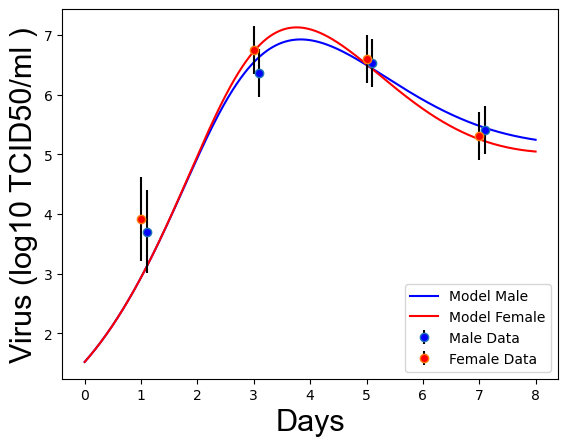

In [12]:
x0 = np.linspace(0,8,1000)
ic_m = np.array([theta_m[-1],1,1])
ic_f = np.array([theta_f[-1],1,1])
sol_m = ode_solve(x0,ic_m,theta_m)
sol_f = ode_solve(x0,ic_f,theta_f)
#uncomment to save solutions to .csv file
#np.savetxt('data_interferon_m.csv',sol_m, delimiter=',')
#np.savetxt('data_interferon_f.csv',sol_f, delimiter=',')
t=np.array([1,3,5,7])
v_stdev = np.array([[0.7],[0.4],[0.4],[0.4]])
Myerr1 = np.hstack((v_stdev,Myerr))
Fyerr1 = np.hstack((v_stdev,Fyerr))

import matplotlib.font_manager as font_manager
csfont = {'fontname':'Arial','fontsize':'22'}
hfont = {'fontname':'Arial','fontsize':'26'}
font_path = 'C:\Windows\Fonts\Calibri.ttf'
font_prop = font_manager.FontProperties(fname=font_path, size=10)

plt.plot(x0,(sol_m[:,0]),'b-',label='Model Male')
plt.plot(x0,(sol_f[:,0]),'r-',label='Model Female')
plt.errorbar(t+.1,Mdata[:,0],yerr=Myerr1[:,0],fmt='o',ecolor="k",linestyle='',mfc='b',label='Male Data')
plt.errorbar(t,Fdata[:,0],yerr=Fyerr1[:,0],fmt='o',ecolor="k",linestyle="",mfc='r',label='Female Data')

plt.xlabel('Days',**csfont)
plt.ylabel('Virus (log10 TCID50/ml )',**csfont)
plt.legend(loc='lower right')
#plt.ylim(0,4)
#plt.title('Virus',**hfont)
#uncomment to save figure
#plt.savefig("strain_fits/rob_V_ML_HillIFN_interferon_"+date+".svg", bbox_inches='tight',format='svg');


Text(0.5, 1.0, 'Interferon')

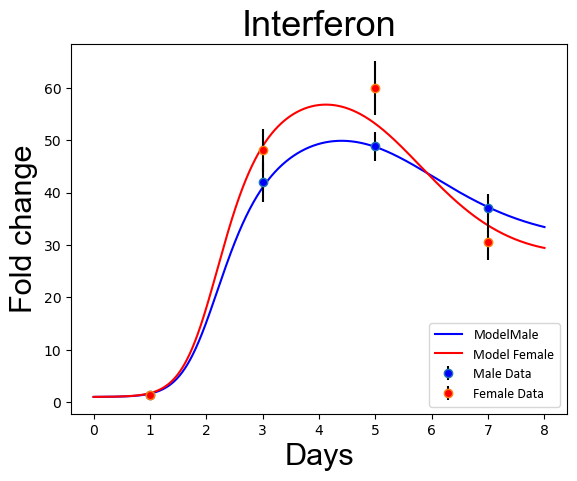

In [13]:
plt.plot(x0,(sol_m[:,1]),'b-',label='ModelMale')
plt.plot(x0,(sol_f[:,1]),'r-',label='Model Female')
plt.errorbar(t,Mdata[:,1],yerr=Myerr1[:,1],fmt='o',ecolor="k",linestyle='',mfc='b',label='Male Data')
plt.errorbar(t,Fdata[:,1],yerr=Fyerr1[:,1],fmt='o',ecolor="k",linestyle="",mfc='r',label='Female Data')

plt.xlabel('Days',**csfont)
plt.ylabel('Fold change',**csfont)
plt.legend(loc='lower right',prop=font_prop)
#plt.ylim(0,4)
plt.title('Interferon',**hfont)
#uncomment to save figure
#plt.savefig("strain_fits/rob_IFN_ML_HillIFN_interferon_"+date+".svg", bbox_inches='tight',format='svg');

Text(0.5, 1.0, 'Macrophage')

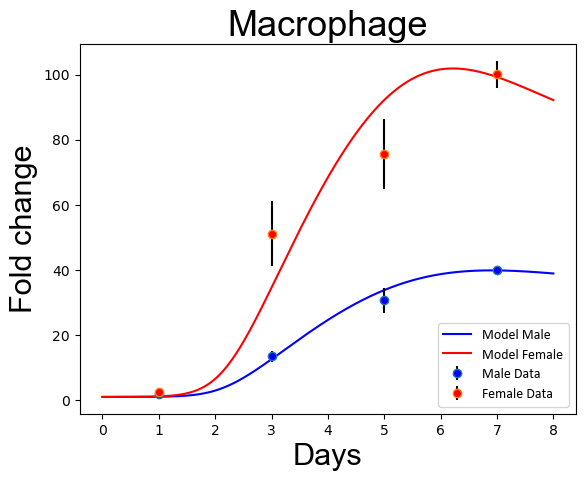

In [14]:
plt.plot(x0,(sol_m[:,2]),'b-',label='Model Male')
plt.plot(x0,(sol_f[:,2]),'r-',label='Model Female')
plt.errorbar(t,Mdata[:,2],yerr=Myerr1[:,2],fmt='o',ecolor="k",linestyle='',mfc='b',label='Male Data')
plt.errorbar(t,Fdata[:,2],yerr=Fyerr1[:,2],fmt='o',ecolor="k",linestyle="",mfc='r',label='Female Data')

plt.xlabel('Days',**csfont)
plt.ylabel('Fold change',**csfont)
plt.legend(loc='lower right',prop=font_prop)
plt.title('Macrophage',**hfont)
#uncomment to save figure
#plt.savefig("strain_fits/rob_Mac_ML_HillIFN_interferon_"+date+".svg", bbox_inches='tight',format='svg');

# Global Sensitivity Analysis Step 1: generate data

- We will perform an analysis to identify **which parameters most effect the steadystate value of P**.
- Randomly perturb the parameters of our model by $\pm 20$% and do this 100 times.
    - Let the perturbations be sampled from a uniform distribution. What function could you use?
- Be sure to safe all of the sets of parameters.
- For each set of perturbed parameters, simulate the ODEs. Plot of responses of our state P and save the final value of P for each simulated state trajectory.

In [ ]:
def f6(u, t, p, ic):
    """3 state ODE model of Virus, IFN, and M"""
   
    k, big_k, r_ifn_v, d_v, p_m_ifn, d_ifn, k1, k2, d_mcp1, n, d_v_mcp1, p_ifn_mcp1, v0 = p
    v, ifn, mcp1 = u
    v0, ifn0, mcp10 = ic
    dv = k*v*(1-v/big_k) - r_ifn_v*(ifn)*v - d_v*v - d_v_mcp1*v*(mcp1-mcp10)
    difn = p_ifn_mcp1*(mcp1-mcp10) - d_ifn*(ifn) +  (k1*(v)**n)/(k2+(v)**n)
    dmcp1 = p_m_ifn*ifn - d_mcp1*(mcp1-mcp10)
    return [dv, difn, dmcp1]

def g2(t,p):
    """Return integration of model"""
    u0 = np.array([p[12],1,1])
    sol = odeint(f6, u0, t, args=(p,u0),mxstep=500000)
    return sol
# generate several output for random selections of parameters
N = 1000;
#uncomment for female
#female best BIC parameter chain
k,K,r_ifn_v,d_v, r_m_ifn, d_ifn, k1, k2, d_m, n1, d_v_m, r_ifn_m, v0 =np.array([7.68245046e-01, 3.74536691e+01 ,7.91020870e-03, 1.25531214e-01,
 1.07219620e+00 ,1.89415901e+00, 1.35869271e+02, 2.23644344e+04,
 3.96629962e-01 ,5.71840052e+00 ,2.73522610e-03 ,7.15053633e-02,
 1.73987502e+00])

#uncomment for male best BIC parameter chain
#k,K,r_ifn_v,d_v, r_m_ifn, d_ifn, k1, k2, d_m, n1, d_v_m, r_ifn_m, v0 = np.array([7.68245046e-01, 3.74536691e+01 ,7.91020870e-03 ,1.25531214e-01,
 #4.14630729e-01 ,1.89415901e+00, 1.35869271e+02 ,2.23644344e+04,
 #3.96629962e-01, 5.71840052e+00 ,6.48933314e-03 ,7.15053633e-02,
 #1.73987502e+00])

k = np.random.uniform(k*.9,k*1.1,N)
K = np.random.uniform(K*.9,K*1.1,N)
r_ifn_v = np.random.uniform(r_ifn_v*.9,r_ifn_v*1.1,N)
d_v = np.random.uniform(d_v*.9,d_v*1.1,N)
r_m_ifn = np.random.uniform(r_m_ifn*.9,r_m_ifn*1.1,N)
d_ifn = np.random.uniform(d_ifn*.9,d_ifn*1.1,N)
k1 = np.random.uniform(k1*.9,k1*1.1,N)
k2 = np.random.uniform(k2*.9,k2*1.1,N)
d_m = np.random.uniform( d_m*.9, d_m*1.1,N)
n1 = np.random.uniform(n1*.9,n1*1.1,N)
d_v_m = np.random.uniform(d_v_m*.9,d_v_m*1.1,N)
r_ifn_m = np.random.uniform(r_ifn_m*.9,r_ifn_m*1.1,N)
v0 = np.random.uniform(v0*.9,v0*1.1,N)
from scipy.integrate import simps
timesteps = np.linspace(0,8,100)

#problem = ProblemSpec({'num_vars':13, 
    #'names': ['k','K_v_v','r_ifn_v','d_v', 'r_m_ifn', 'd_ifn', 'k1', 'k2', 'd_m', 'n1', 'd_v_m', 'r_ifn_m', 'v0'],
    #'bounds': [[2, 3],[21, 23],[.9e-11, 1.1e-11],[1,2],
    #[.1,.2],[9,11],[450,550],[400000,500000],
    #[8e-8,8.5e-8 ],[7,9],[.01,.02],[1,2],[1.00000000e+00, 2.00000000e+00]],
    #'outputs':['Virus','Interferon','Macrophage']})
auc_v = np.zeros((N,1))
auc_f = np.zeros((N,1))
auc_m = np.zeros((N,1))
V = np.zeros((N,100));
IFN = np.zeros((N,100));
M = np.zeros((N,100));
for m in np.arange(0,N,1):
    output = g2(timesteps, np.array([k[m],K[m],r_ifn_v[m],d_v[m],r_m_ifn[m],d_ifn[m],k1[m],k2[m],d_m[m],n1[m],d_v_m[m],r_ifn_m[m],v0[m]]));
    
    V[m,:]=output[:,0];
    IFN[m,:]=output[:,1];
    M[m,:]=output[:,2];
    auc_v[m,:] = simps(V[m,:],timesteps, axis = 0);
    auc_f[m,:] = simps(IFN[m,:],timesteps, axis = 0);
    auc_m[m,:] = simps(M[m,:],timesteps, axis = 0);

print(np.shape(auc_v))

(1000, 1)


# Global Sensitivity Analysis Step 2: visualize your parameter space

- All complex analysis requires baby steps.
- Always visualize each state to make sure your code did what you expected.
- In the space below, plot a histogram of each parameter's value distribution. 
- Are they evenly distributed? Do they go $\pm 20$% of the parameter's nominal value?

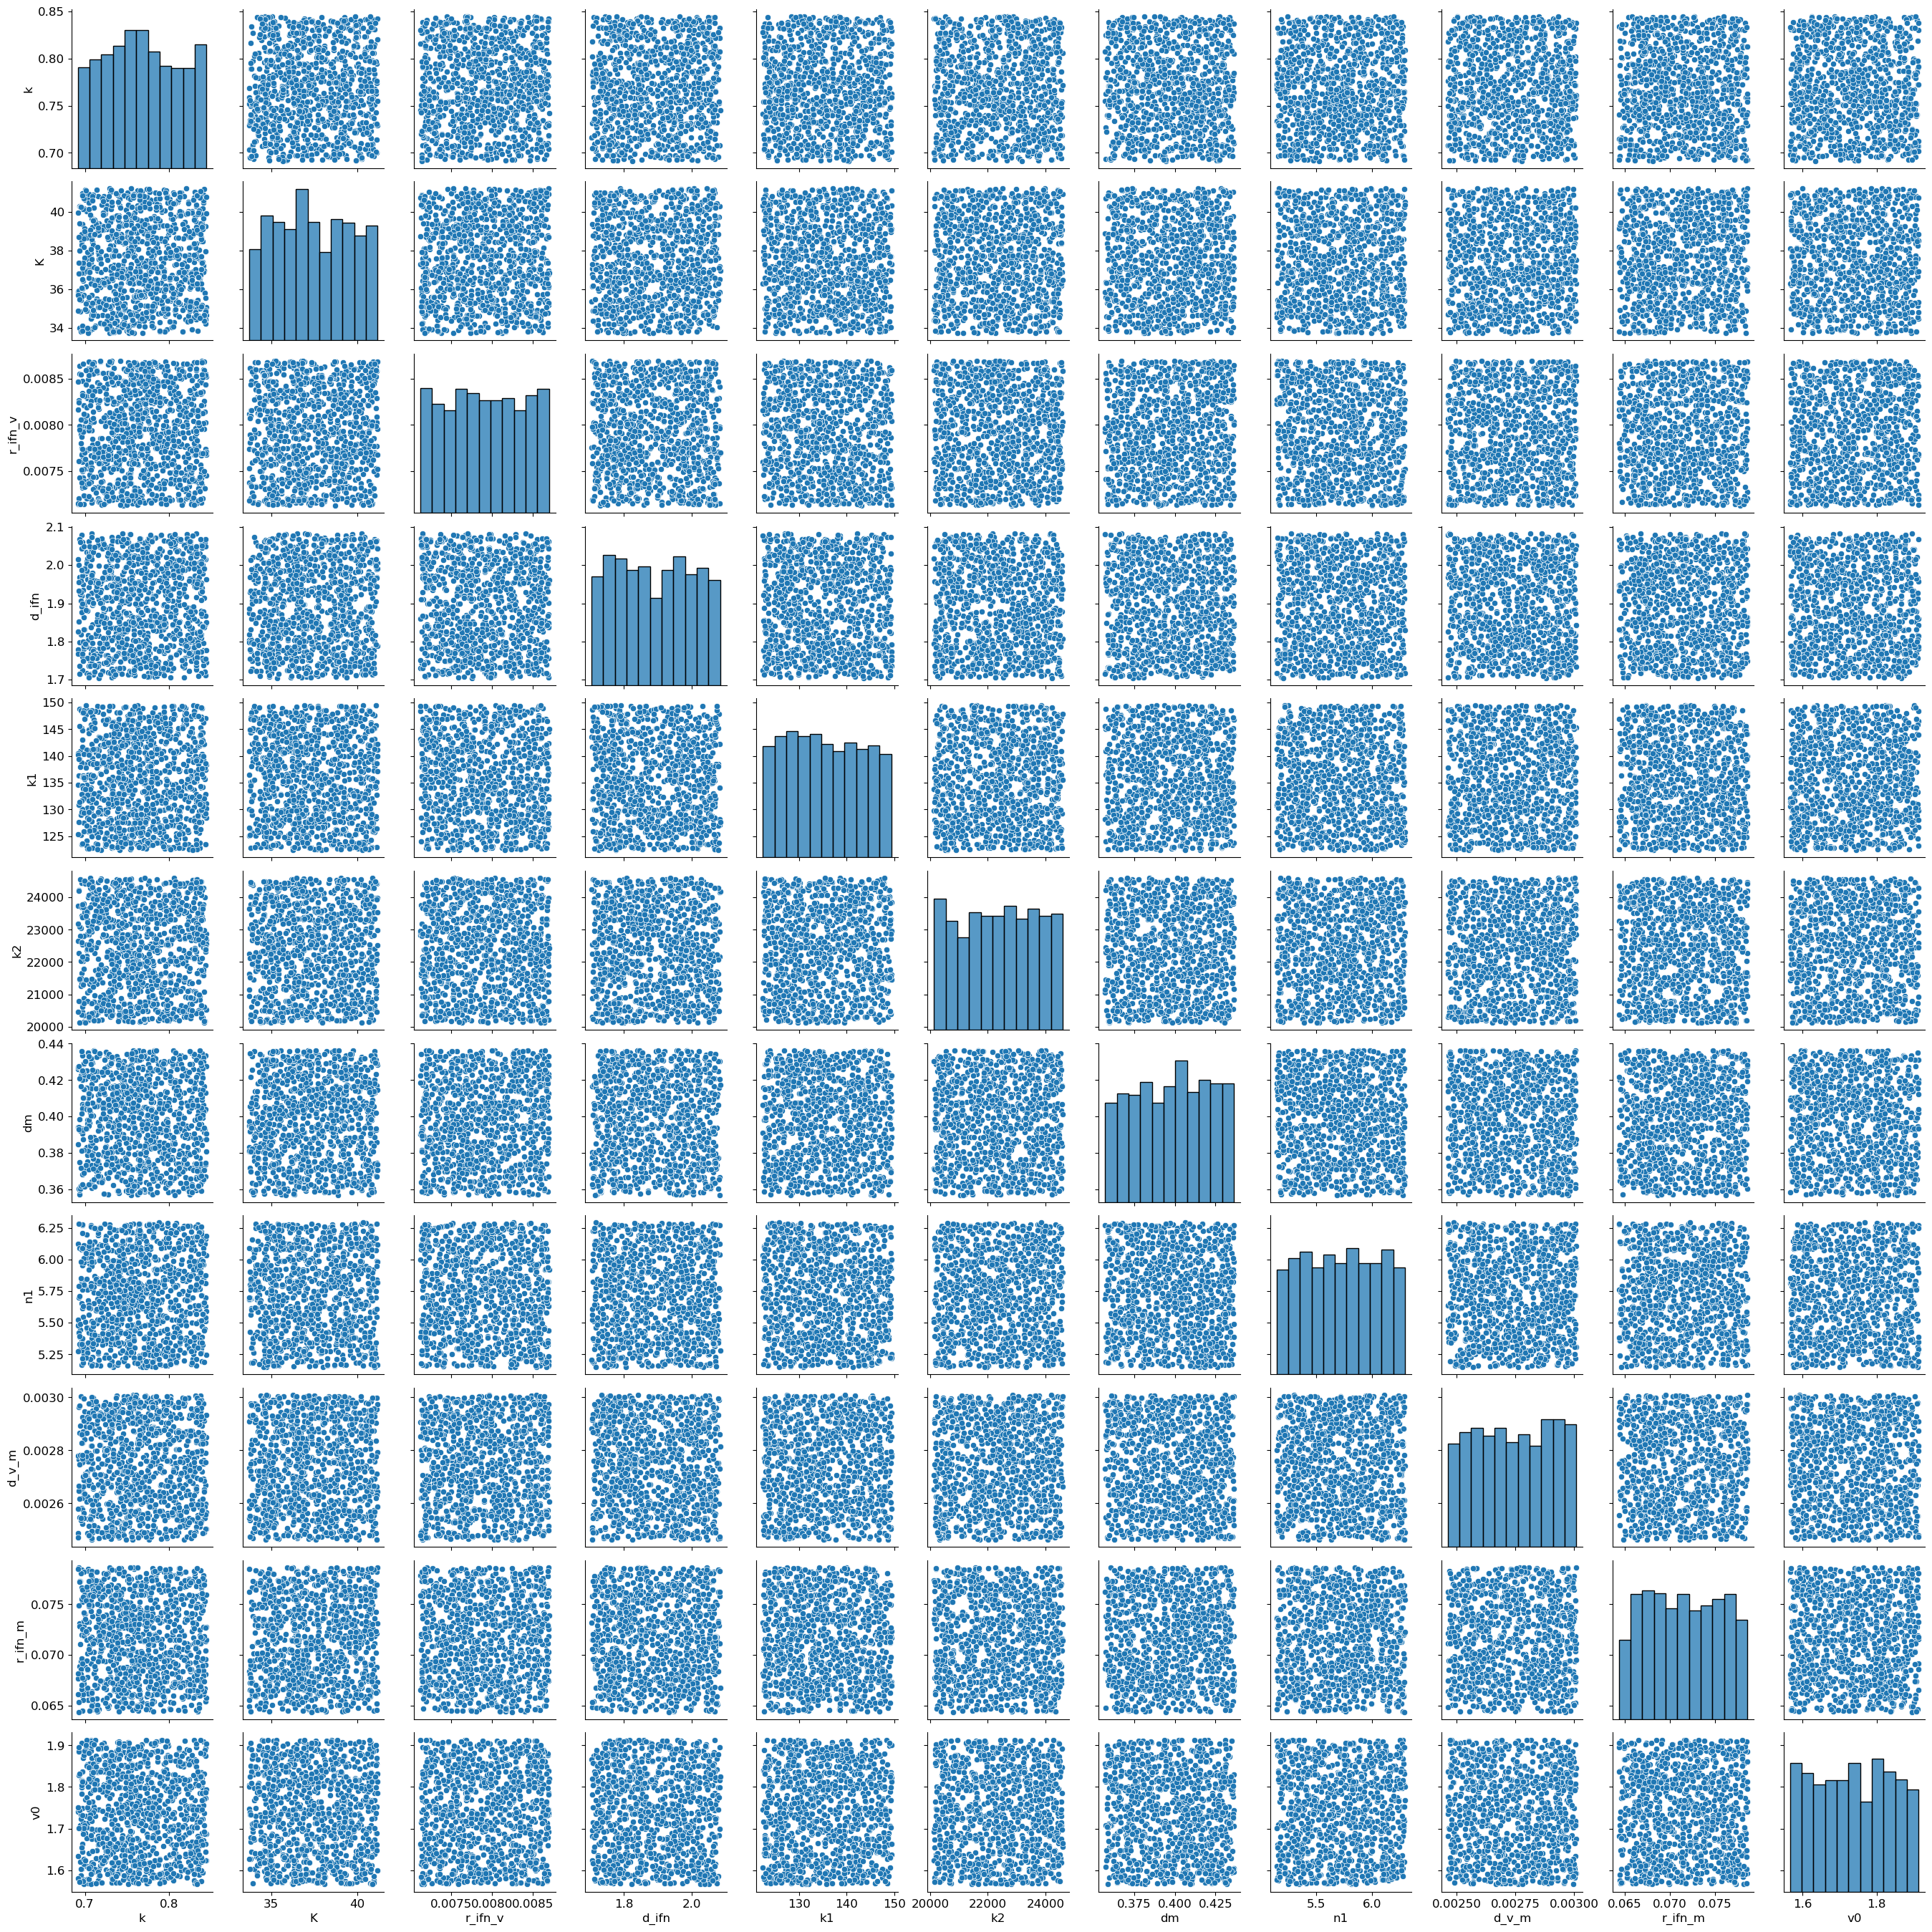

In [ ]:
# Plot histograms of sampled parameter space
import pandas as pd
import seaborn as sns

tmp = {'k':k, 'K':K, 'r_ifn_v':r_ifn_v, 'd_ifn':d_ifn, 'k1':k1,'k2':k2, 'dm':d_m, 'n1':n1, 'd_v_m':d_v_m, 'r_ifn_m':r_ifn_m, 'v0':v0};
df = pd.DataFrame(tmp);
del(tmp)

sns.pairplot(df)  
20

plt.show()

# Global Sensitivity Analysis Step 3: Use least squares to estimate the normalized sensitivities 

- Revisit your least squares regression code for linear systems where the model has **no intercept**
- Which parameter is most important to our output, P?

In [ ]:
# Now we have our output of interest, called P. Using our old least squares code, let y = P and normalize the values by
# the value of P's steadystate for the nominal parameter values. This was calculated in step 1 above.
#Going to need to use Vmax, Fmax, Mmax here
#use AUC
# Normalize y
y = g2(timesteps, np.array([1.433,25.23,.00000056841,.552858,1.074,5.669,549.0483,556.006,0.44966,3.3446,0.006951451,0.24448179,1.013]))
nominal_auc = simps(y,timesteps, axis = 0);
yv = (nominal_auc[0]-auc_v)/nominal_auc[0] # See first set of code to find this number
yf = (nominal_auc[1]-auc_f)/nominal_auc[1]
ym = (nominal_auc[2]-auc_m)/nominal_auc[2]

sim_params=np.reshape(np.array([k,K,r_ifn_v,d_v,r_m_ifn,d_ifn,k1,k2,d_m,n1,d_v_m,r_ifn_m,v0]),(13,1000)).T
print(np.shape(sim_params))
# Build our X. Normalize values
real_params = np.reshape(np.array([7.68245046e-01, 3.74536691e+01 ,7.91020870e-03, 1.25531214e-01,
 1.07219620e+00 ,1.89415901e+00, 1.35869271e+02, 2.23644344e+04,
 3.96629962e-01 ,5.71840052e+00 ,2.73522610e-03 ,7.15053633e-02,
 1.73987502e+00]),(1,13))
#check X math
#X = np.zeros((1000,13))
X = (real_params-sim_params)/real_params

print(np.shape(X))
# Now can just do the linear least squares estimate
#===================================================


# # Use a different toolbox. R is way better at this...

import statsmodels.api as sm
model = sm.OLS(yv, X).fit()
print(model.summary())


model = sm.OLS(yf, X).fit()
print(model.summary())

model = sm.OLS(ym, X).fit()
print(model.summary())



(1000, 13)
(1000, 13)
[[ 0.58360903  0.10008319 -0.22878964 -0.10788669 -0.16354956  0.31838344
  -0.38122831  0.15393925  0.10711346 -1.4101234  -0.09505484 -0.01463789
   0.1366406 ]]
0.8029716684646511
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.834
Model:                            OLS   Adj. R-squared (uncentered):              0.832
Method:                 Least Squares   F-statistic:                              381.2
Date:                Wed, 20 Sep 2023   Prob (F-statistic):                        0.00
Time:                        10:00:10   Log-Likelihood:                          1773.2
No. Observations:                1000   AIC:                                     -3520.
Df Residuals:                     987   BIC:                                     -3457.
Df Model:                          13                                                  
Cov

In [ ]:
#saved sensitivity analysis results for male and female parameters
SA = np.genfromtxt('sensitivity_analysis_rob2011_mac.txt')
print(SA)
SA_params = np.array(["k","K","$r_{v,ifn}$","$d_v$","$r_{m,ifn}$","$d_{ifn}$","K1","K2","$d_m$","n","$r_{v,m}$","$r_{ifn,m}$","v0"])
with plt.style.context('fast'):
    fig, axs = plt.subplots(3, 1, layout='constrained', figsize=(8, 12))
    #gridspec = axs[00].get_subplotspec().get_gridspec()
    #plt.xticks(t + width/2,['1','3','5','7'])

    # plot data in remaining axes:
    width = 0.25
    ti = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13])
    plt.setp(axs, xticks=ti+width/2, xticklabels=SA_params)
    
    axs[0].bar(ti,SA[:,1],align='center',  color='b', capsize=6, width=width, label='Male')
    axs[0].bar(ti+width,SA[:,2],align='center',  color='r',capsize=6, width=width, label='Female')
    #axs[0,0].set_title("Virus")
    #axs[0].errorbar(t,Fdata[:,0],yerr=Fyerr1[:,0],fmt='ko',ecolor="k",linestyle='',mfc='k')
    axs[0].set_ylabel("Coefficient Value", labelpad=26)
    #axs[0].set_xlabel('Days Post Infection')
    axs[0].axhline(y=0,color='k')
    axs[0].set_ylim(bottom=-2, top=2)

    axs[1].bar(ti,SA[:,3],align='center',  color='b', capsize=6, width=width, label='Male')
    axs[1].bar(ti+width,SA[:,4],align='center',  color='r',capsize=6, width=width, label='Female')
    axs[1].set_ylabel('Coefficient Value', labelpad=26)
    axs[1].set_ylim(bottom=-2, top=2)
    axs[1].axhline(y=0,color='k')

    axs[2].bar(ti,SA[:,5],align='center',  color='b', capsize=6, width=width, label='Male')
    axs[2].bar(ti+width,SA[:,6],align='center',  color='r',capsize=6, width=width, label='Female')
    #axs[0,2].set_title("Macrophage")
    #axs[2].errorbar(t,Fdata[:,2],yerr=Fyerr1[:,2],fmt='ko',ecolor="k",linestyle='',mfc='k')
    axs[2].set_ylabel('Coefficient Value', labelpad=26)
    axs[2].set_xlabel('Parameter')
    axs[2].set_ylim(bottom=-2, top=2)
    axs[2].axhline(y=0,color='k')